In [2]:
#importing libraries
import os
import shutil
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
import pandas as pd
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

C:\Users\abhay\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#importing dataset, the dataset used can be found here: 
# http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
current_dir = os.getcwd()
print(current_dir)
dataset_path = current_dir + '\\aclImdb'
print(os.listdir(dataset_path))
train_dir = dataset_path + '\\train'
test_dir = dataset_path + '\\test'
print(os.listdir(train_dir))
print(os.listdir(test_dir))

C:\Users\abhay\Downloads\aclImdb_v1
['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']
['labeledBow.feat', 'neg', 'pos', 'unsup', 'unsupBow.feat', 'urls_neg.txt', 'urls_pos.txt', 'urls_unsup.txt']
['labeledBow.feat', 'neg', 'pos', 'urls_neg.txt', 'urls_pos.txt']


Description of the dataset:

Large Movie Review Dataset v1.0

Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided.

Dataset

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include an additional 50,000 unlabeled
documents for unsupervised learning.

In the entire collection, no more than 30 reviews are allowed for any
given movie because reviews for the same movie tend to have correlated
ratings. Further, the train and test sets contain a disjoint set of
movies, so no significant performance is obtained by memorizing
movie-unique terms and their associated with observed labels.  In the
labeled train/test sets, a negative review has a score <= 4 out of 10,
and a positive review has a score >= 7 out of 10. Thus reviews with
more neutral ratings are not included in the train/test sets. In the
unsupervised set, reviews of any rating are included and there are an
even number of reviews > 5 and <= 5.


In [17]:
#function to load the dataset into pandas dataframe
def get_pandas_dataset(file_directory):
    data={'review':[],'sentiment':[]} #creating a dictionary to store reviews and their corresponding sentiments
    for file_name in os.listdir(file_directory):
        print(file_name)
        if file_name == 'pos':
            pos_file = os.path.join(file_directory,file_name)
            for file in os.listdir(pos_file):
                with open(os.path.join(pos_file,file), 'r', encoding='utf-8') as f:
                    data['review'].append(f.read())
                    data['sentiment'].append(1) # 1 is for positive sentiment
        elif file_name == 'neg':
            neg_file = os.path.join(file_directory,file_name)
            for file in os.listdir(neg_file):
                with open(os.path.join(neg_file,file), 'r', encoding='utf-8') as f:
                    data['review'].append(f.read()) # 0 is for negative sentiment
                    data['sentiment'].append(0)
    return pd.DataFrame.from_dict(data)

In [18]:
#loading the training dataset
train_df = get_pandas_dataset(train_dir)
train_df.head()

labeledBow.feat
neg
pos
unsup
unsupBow.feat
urls_neg.txt
urls_pos.txt
urls_unsup.txt


,review,sentiment
0,Story of a man who has unnatural feelings for ...,0
1,Airport '77 starts as a brand new luxury 747 p...,0
2,This film lacked something I couldn't put my f...,0
3,"Sorry everyone,,, I know this is supposed to b...",0
4,When I was little my parents took me along to ...,0


In [19]:
#loading the test dataset
test_df = get_pandas_dataset(test_dir)
test_df.head()

labeledBow.feat
neg
pos
urls_neg.txt
urls_pos.txt


,review,sentiment
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


sentiment
0    12500
1    12500
Name: count, dtype: int64


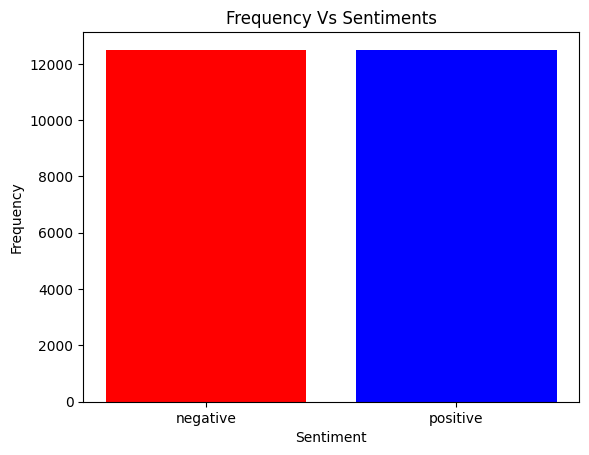

In [20]:
#visualising the distribution of sentiment in training dataset

values = train_df['sentiment'].value_counts()
print(values)
count_0 = values[0]
count_1 = values[1]

counts = [count_0, count_1]
categories = ['negative', 'positive']

plt.bar(categories,counts,color = ['red', 'blue'])

plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Frequency Vs Sentiments')
plt.show()



In [21]:
#function to clean the text
def clean_text(text):
    soup = BeautifulSoup(text, "html.parser") #HTML parser to remove html tags
    text = re.sub(r'\[[^]]*\]', '', soup.get_text()) #removing content in brackets
    pattern = r"[^a-zA-Z0-9\s,']" #removing special characters
    text = re.sub(pattern, '', text)
    return text

In [22]:
# clean the reviews in the train_df
train_df['clean_review'] = train_df['review'].apply(clean_text).tolist()
# clean the reviews in the test_df
test_df['clean_review'] = test_df['review'].apply(clean_text).tolist()

C:\Users\abhay\AppData\Local\Temp\ipykernel_19040\3159851022.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser") #HTML parser to remove html tags
C:\Users\abhay\AppData\Local\Temp\ipykernel_19040\3159851022.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser") #HTML parser to remove html tags


In [23]:
#function to generate a wordcloud of positive and negative review
def gen_wordcloud(text, title):
    string = " ".join(text)
    wordcloud = WordCloud(width=800,
                          height=400,
                          stopwords=set(STOPWORDS),
                          background_color='black').generate(string)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

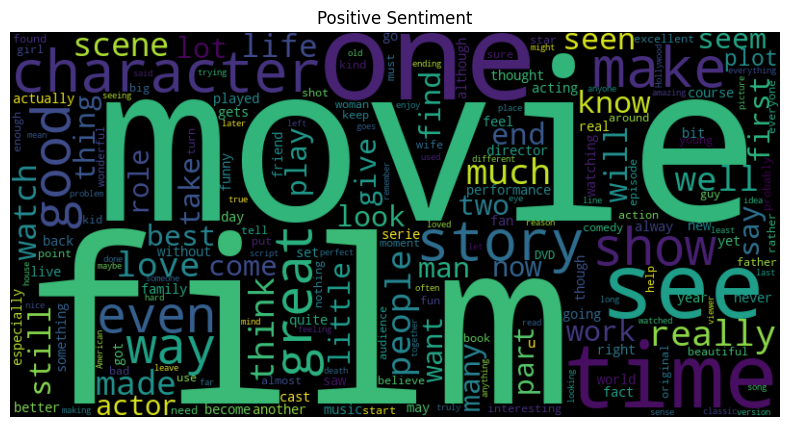

In [24]:
#generate wordcloud for positive reviews
positive_review = train_df[train_df['sentiment']==1]['clean_review'].tolist()
gen_wordcloud(positive_review, "Positive Sentiment")

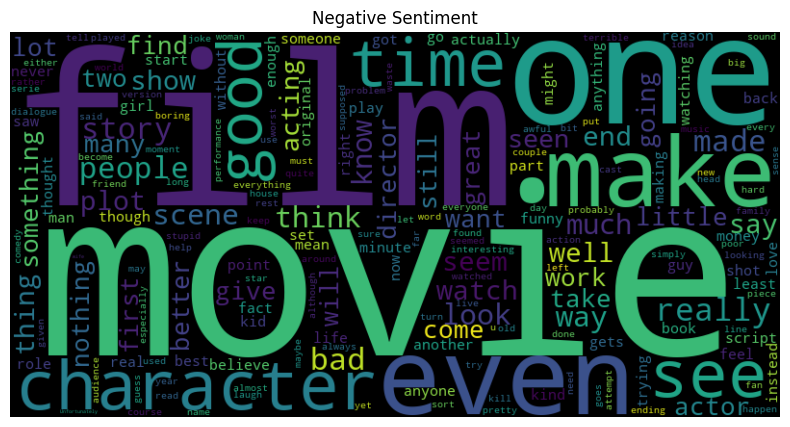

In [25]:
#generate wordcloud for negative reviews
negative_review = train_df[train_df['sentiment']==0]['clean_review'].tolist()
gen_wordcloud(negative_review,'Negative Sentiment')

In [26]:
#seperating review and sentiments
#from train_df
review = train_df['clean_review']
senti = train_df['sentiment']
#from test_df
test_review = test_df['clean_review']
test_senti = test_df['sentiment']

In [27]:
#generating validation and test data from test dataset
X_val, X_test, y_val, y_test = train_test_split(test_review,
                                                    test_senti,
                                                    test_size=0.5,
                                                    stratify = test_senti)

Now we need to tokenize the text (convert them into numerical inputs) to feed it into the BERT model, for this we will use BERT Tokenizer.

### BERT Tokenization

BERT tokenization refers to the process of breaking down a piece of text (a sentence or a sequence of words) into smaller units called tokens that BERT can understand and process. Tokenization is a crucial step in natural language processing (NLP) tasks, as it transforms raw text into a format that machine learning models like BERT can work with effectively.

#### How BERT Tokenization Works:

1. **Basic Tokenization**:
   - **Word-Level**: The text is split into individual words or subwords using a vocabulary that maps words to indices. BERT uses a WordPiece tokenizer, which breaks words into meaningful subword units. For example, "playing" might be split into "play" and "##ing".
   - **Character-Level**: Characters can also be used as tokens, especially for languages with complex scripts or when dealing with very small units of text.

2. **Special Tokens**:
   - **[CLS]**: BERT requires a special `[CLS]` token appended to the beginning of each input sequence. This token is used to denote the start of a classification task.
   - **[SEP]**: A `[SEP]` token is used to separate pairs of sentences or indicate the end of a single sentence. It helps BERT understand the boundaries between sentences during training or inference.

3. **Token IDs**:
   - Each token in the text is mapped to a unique integer ID from BERT's vocabulary. This vocabulary is usually large and contains both common words and
   - input_ids: The numerical identifiers of the vocabulary tokens
   - token_type_ids: It identifies which segment or sentence each token belongs to.
   - attention_mask: It flags that inform the model which tokens to pay attention to and which to disregard. subword units.

4. **Padding and Truncation**:
   - BERT requires all input sequences to have the same length. If a sequence is shorter than the maximum length, it is padded with `[PAD]` tokens. If it is longer
sord., it is truncated.

#### Example of BERT Tokenization:

Let's consider an example sentence: "BERT tokenization explains how BERT processes text."

After tokenization, this sentence might look like:
- Tokens: `[CLS]`, "BERT", "token", "##ization", "explains", "how", "BERT", "processes", "text", ".", `[SEP]`
- Token IDs: `[101]`, 14324, 19204, 3119, 7573, 2129, 14324, 6945, 3793, 119, `[102]`

#### Purpose of Tokenization in BERT:

Tokenization is essential for BERT and similar models because:
- It converts text into a format that the model can process numerically.
- It handles out-of-vocabulary words by breaking them into known subwords.
- It includes special tokens that provide context and structure to the input sequences.

BERT's tokenization process ensures that the model can effectively learn and understand the relationships between words and their contexts in natural language text, enabling it to perform tasks such as text classification, question answering, and language modeling with high accuracy.
 input sequences. is truncated.

In [28]:
#first we need to import the pre-trained BERT tokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [29]:
# Tokenize and encode the sentences
max_len= 128
X_train_encoded = tokenizer.batch_encode_plus(review.tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

X_val_encoded = tokenizer.batch_encode_plus(X_val.tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

X_test_encoded = tokenizer.batch_encode_plus(X_test.tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

In [30]:
#check the encoded dataset
print('Training reviews -->>',review[10])
print('\nInput Ids -->>\n',X_train_encoded['input_ids'][10])
print('\nDecoded Ids -->>\n',tokenizer.decode(X_train_encoded['input_ids'][10]))
print('\nAttention Mask -->>\n',X_train_encoded['attention_mask'][10])
print('\nLabels -->>',senti[10])

Training reviews -->> This film is one giant pant load Paul Schrader is utterly lost in his own bad screenplay And his directing is about as comatose as it can be without his actually having been sleepwalking during the process The worst though is Woody Harrelson, whom I ordinarily like when he's properly cast He plays the walker, a homosexual man in DC who plays social companion to the bored wives of the Washington elite He couldn't have been more one dimensional if he had been cut out of a magazine and bounced around in front of the camera on a popsicle stick His southern accent is that off the rack version that decrescendos from the beginning to the end of every line he delivers, as though the heat and humidity of the South is still draining him of every ounce of energy he has It is monotonous But, his is not the worst accent in the movie His boyfriend, played by Moritz Bleibtreau, attempts to affect some kind of a Mid East accent that is so clumsy he can barely deliver the bad line

#### Now we need to build the classification model which is basically pretrained BERT+ ffNN
---------------------
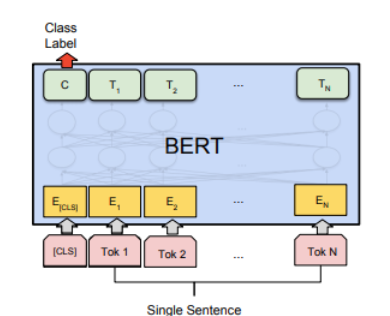-


In [9]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
# Compile the model with an appropriate optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [23]:
# Train the model
history = model.fit(
    [X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']],
    senti,
    validation_data=(
      [X_val_encoded['input_ids'], X_val_encoded['token_type_ids'], X_val_encoded['attention_mask']],y_val),
    batch_size=32,
    epochs=3
)

Epoch 1/3


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
782/782 [==============================] - 884s 1s/step - loss: 0.3424 - accuracy: 0.8469 - val_loss: 0.2652 - val_accuracy: 0.8868
Epoch 2/3
782/782 [==============================] - 803s 1s/step - loss: 0.1993 - accuracy: 0.9208 - val_loss: 0.2812 - val_accuracy: 0.8914
Epoch 3/3
782/782 [==============================] - 802s 1s/step - loss: 0.1043 - accuracy: 0.9625 - val_loss: 0.3737 - val_accuracy: 0.8806


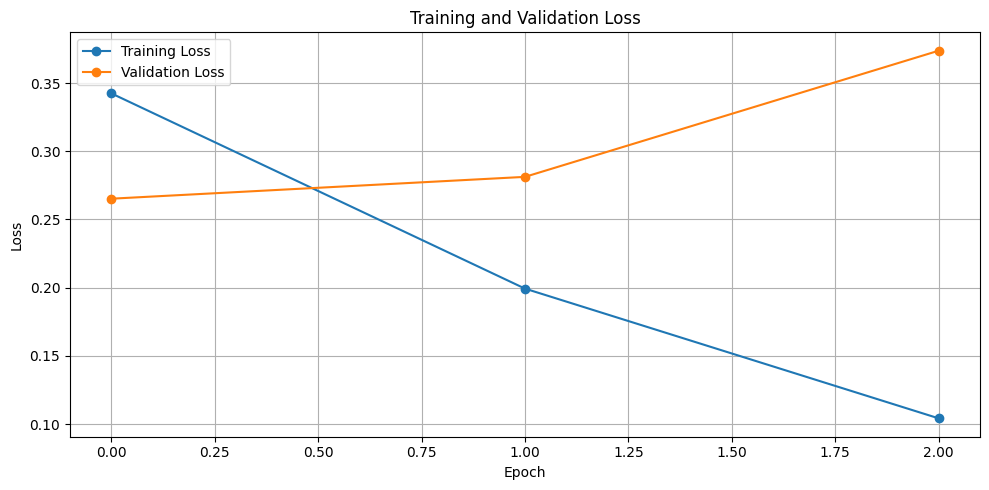

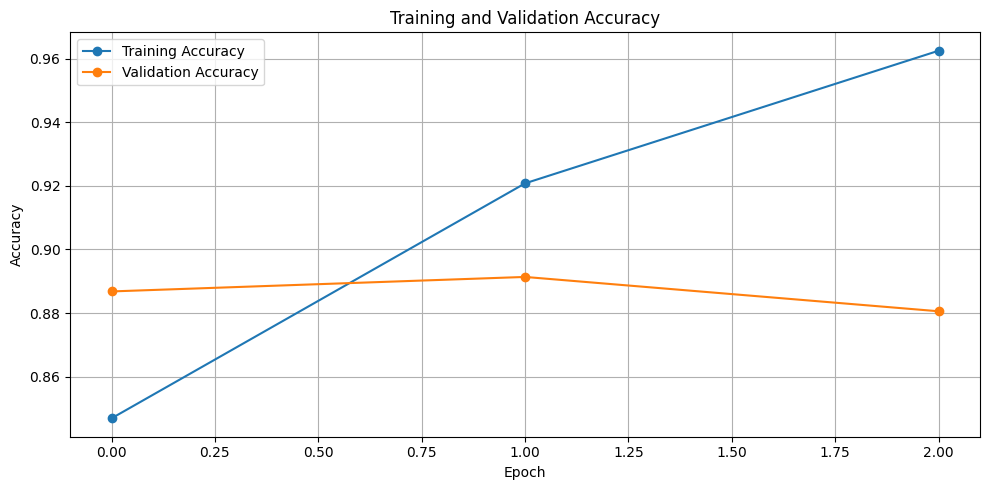

In [24]:
# visualising training and validation loss and accuracy
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# loss
plt.figure(figsize=(10, 5))
plt.plot(training_loss, label='Training Loss', marker='o')
plt.plot(validation_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# accuracy
plt.figure(figsize=(10, 5))
plt.plot(training_accuracy, label='Training Accuracy', marker='o')
plt.plot(validation_accuracy, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
#Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(
    [X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']],
    y_test
)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

391/391 [==============================] - 112s 287ms/step - loss: 0.3749 - accuracy: 0.8781
Test loss: 0.37487468123435974, Test accuracy: 0.8780800104141235


In [ ]:
#Saving our trained model
path = os.getcwd()
# Save tokenizer
tokenizer.save_pretrained(path +'/Tokenizer')

# Save model
model.save_pretrained(path +'/Model')

In [15]:
# Load tokenizer
path = os.getcwd()
bert_tokenizer = BertTokenizer.from_pretrained(path +'\Tokenizer')

# Load model
bert_model = TFBertForSequenceClassification.from_pretrained(path +'\Model\Model')

Some layers from the model checkpoint at C:\Users\abhay\Downloads\aclImdb_v1\Model\Model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at C:\Users\abhay\Downloads\aclImdb_v1\Model\Model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [31]:
#predict the sentiment of the test dataset
pred = bert_model.predict(
    [X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']])

# pred is of type TFSequenceClassifierOutput
logits = pred.logits

# Use argmax along the appropriate axis to get the predicted labels
pred_labels = tf.argmax(logits, axis=1)

# Convert the predicted labels to a NumPy array
pred_labels = pred_labels.numpy()

label = {
    1: 'positive',
    0: 'Negative'
}

# Map the predicted labels to their corresponding strings using the label dictionary
pred_labels = [label[i] for i in pred_labels]
Actual = [label[i] for i in y_test]

print('Predicted Label :', pred_labels[:10])
print('Actual Label    :', Actual[:10])

391/391 [==============================] - 2961s 8s/step
Predicted Label : ['positive', 'positive', 'positive', 'Negative', 'positive', 'positive', 'positive', 'positive', 'Negative', 'positive']
Actual Label    : ['positive', 'Negative', 'positive', 'Negative', 'positive', 'positive', 'positive', 'Negative', 'Negative', 'positive']


In [33]:

print("Classification Report: \n", classification_report(Actual, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.93      0.83      0.87      6250
    positive       0.84      0.94      0.89      6250

    accuracy                           0.88     12500
   macro avg       0.89      0.88      0.88     12500
weighted avg       0.89      0.88      0.88     12500



In [32]:
# this function is to test user given reviews for positive or negative sentiment

def get_sentiment(review, Tokenizer=bert_tokenizer, Model=bert_model):
    # Convert Review to a list if it's not already a list
    if not isinstance(review, list):
        review = [review]

    Input_ids, Token_type_ids, Attention_mask = Tokenizer.batch_encode_plus(Review,
                                                                             padding=True,
                                                                             truncation=True,
                                                                             max_length=128,
                                                                             return_tensors='tf').values()
    pred = Model.predict([Input_ids, Token_type_ids, Attention_mask])

    # Use argmax along the appropriate axis to get the predicted labels
    pred_labels = tf.argmax(pred.logits, axis=1)

    # Convert the TensorFlow tensor to a NumPy array and then to a list to get the predicted sentiment labels
    pred_labels = [label[i] for i in pred_labels.numpy().tolist()]
    return pred_labels